<a href="https://colab.research.google.com/github/sbooeshaghi/picasso/blob/main/gorilla/gorilla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%cd /content/

/content


## **Download Example Data Matrix**

In [3]:
import requests
import os

#La Manno et al. 2020, Developing Mouse Brain data
from tqdm import tnrange, tqdm_notebook
def download_file(doi,ext):
	url = 'https://api.datacite.org/dois/'+doi+'/media'
	r = requests.get(url).json()
	netcdf_url = r['data'][0]['attributes']['url']
	r = requests.get(netcdf_url,stream=True)
	#Set file name
	fname = doi.split('/')[-1]+ext
	#Download file with progress bar
	if r.status_code == 403:
		print("File Unavailable")
	if 'content-length' not in r.headers:
		print("Did not get file")
	else:
		with open(fname, 'wb') as f:
			total_length = int(r.headers.get('content-length'))
			pbar = tnrange(int(total_length/1024), unit="B")
			for chunk in r.iter_content(chunk_size=1024):
				if chunk:
					pbar.update()
					f.write(chunk)
		return fname


#10x VMH data
#metadata.csv
download_file('10.22002/D1.2067','.gz')

#smartseq.mtx (log counts)
download_file('10.22002/D1.2071','.gz')



os.system("gunzip *.gz")

os.system("mv D1.2067 metadata.csv")
os.system("mv D1.2071 smartseq.mtx")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


  0%|          | 0/64 [00:00<?, ?B/s]

  0%|          | 0/26700 [00:00<?, ?B/s]

0

In [4]:
!git clone https://github.com/sbooeshaghi/picasso

fatal: destination path 'picasso' already exists and is not an empty directory.


In [5]:
%cd /content/picasso

/content/picasso


In [6]:
!pip3 install --quiet torch
!pip3 install --quiet anndata
!pip3 install --quiet matplotlib
!pip3 install --quiet scikit-learn
!pip3 install --quiet torchsummary
!pip install --quiet scanpy==1.6.0
!pip3 install --quiet umap-learn

## **Install Packages**

In [7]:
from Picasso import Picasso

import anndata 
import pandas as pd
import numpy as np

import random
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import NeighborhoodComponentsAnalysis, NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import scale
import torch
import time
import scanpy as sc
import seaborn as sns
import umap
from scipy import stats
import scipy.io as sio
import matplotlib
matplotlib.rc('axes',edgecolor='black')
%matplotlib inline
sc.set_figure_params(dpi=125)
sns.set_style('white')

## **Import Data**

In [8]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.1

state = 42
ndims = 2

data_path = '../'

pcs = 50
n_latent = 50

Numpy matrix for input (3850 cells x 1999 genes)

In [9]:
count_mat = sio.mmread(data_path+'/smartseq.mtx')
count_mat.shape

(3850, 1999)

In [10]:
#Center and scale log-normalized data
scaled_mat = scale(count_mat)

Metadata to color cells/points

In [11]:
meta = pd.read_csv(data_path+'/metadata.csv',index_col = 0)
meta.head()

,sample_name,smartseq_cluster_id,smartseq_cluster,sex_label,smartseq_cluster_color,medical_cond_label,cell_counts,n_genes,percent_mito,pass_count_filter,pass_mito_filter
SM-GE4R2_S062_E1-50,SM-GE4R2_S062_E1-50,46,Nr5a1_9|11 Rorb,M,#6C39A6,behavior - none,964371.56,9772,0.0,True,True
SM-GE4SI_S356_E1-50,SM-GE4SI_S356_E1-50,46,Nr5a1_9|11 Rorb,M,#6C39A6,behavior - none,973072.06,8253,0.0,True,True
SM-GE4SI_S172_E1-50,SM-GE4SI_S172_E1-50,46,Nr5a1_9|11 Rorb,M,#6C39A6,behavior - none,977132.60,9394,0.0,True,True
LS-15034_S07_E1-50,LS-15034_S07_E1-50,42,Nr5a1_4|7 Glipr1,M,#763BFF,behavior - none,948605.44,10643,0.0,True,True
LS-15034_S28_E1-50,LS-15034_S28_E1-50,42,Nr5a1_4|7 Glipr1,F,#763BFF,behavior - none,951803.00,10550,0.0,True,True


Set colors for plotting (list of colors for 3850 cells)

In [12]:
clus_colors = list(pd.unique(meta.smartseq_cluster_color))


Function for plotting latent space with cells colored by given labels

In [13]:
def obj_plot_embed(latent, cluster_label, fname = None, colors = [], alpha=0.4,figsize=(7,5)):
	""" Plot latent space in 2D and color cells by cluster_label """

	fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=figsize)
	#cm.get_cmap("tab20")
	cluster_labels = pd.unique(cluster_label)

	cmap = np.random.rand(len(cluster_labels),3)

	for i, c in (enumerate(cluster_labels)):

		XX = latent[cluster_label == c,:]
		x = XX[:,0]
		y = XX[:,1]

		if(len(colors) >= len(cluster_labels)):
			color = colors[i]
		else:
			color = cmap[i,:]

		ax.scatter(x, y, s=5, alpha = alpha, label=c, color = color)
		
	ax.legend(loc='center left',bbox_to_anchor=(1, 0.5),prop={'size': 8},frameon=False,ncol=2)
	ax.set_axis_off()

	fig.tight_layout()
	if(fname != None):
		plt.savefig(fname)
	else:
		plt.show()

### **Run Picasso**

#### **Define your own shape coordinates**

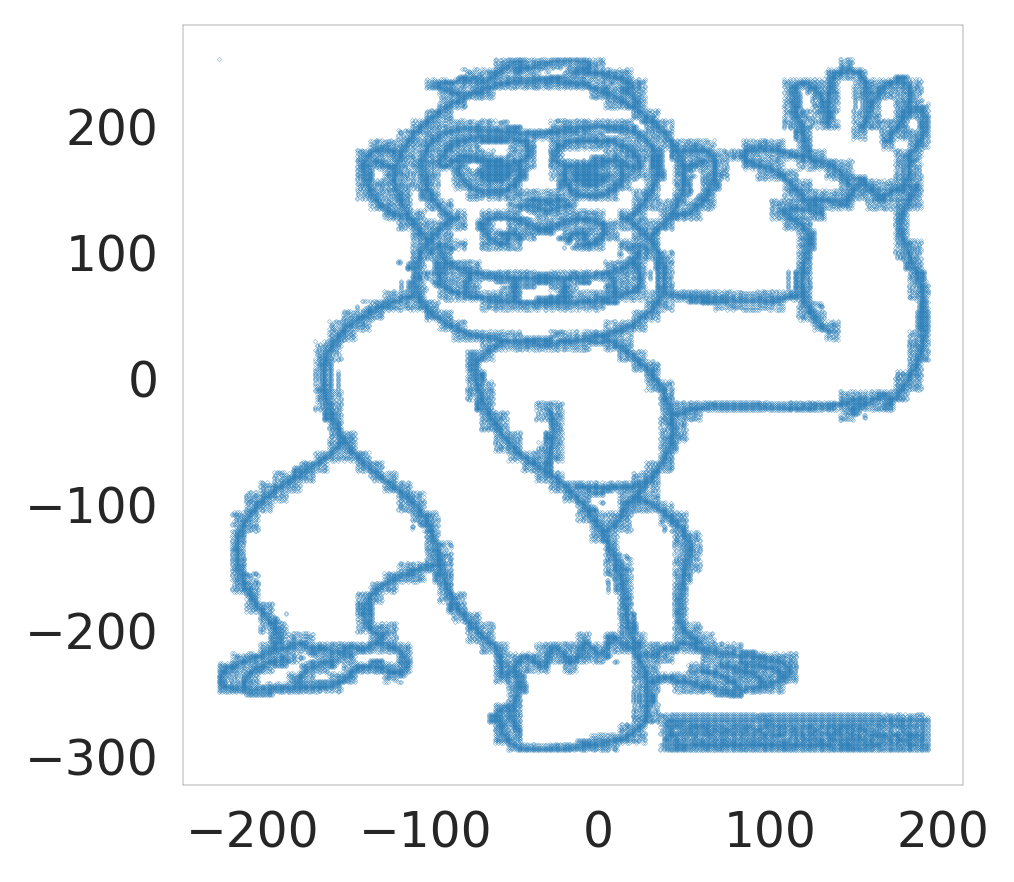

In [14]:
coords = pd.read_csv("./gorilla/coordinates.txt", sep="\t", names=["x","y"], header=None)
plt.scatter(coords["x"], coords["y"], s=0.01)

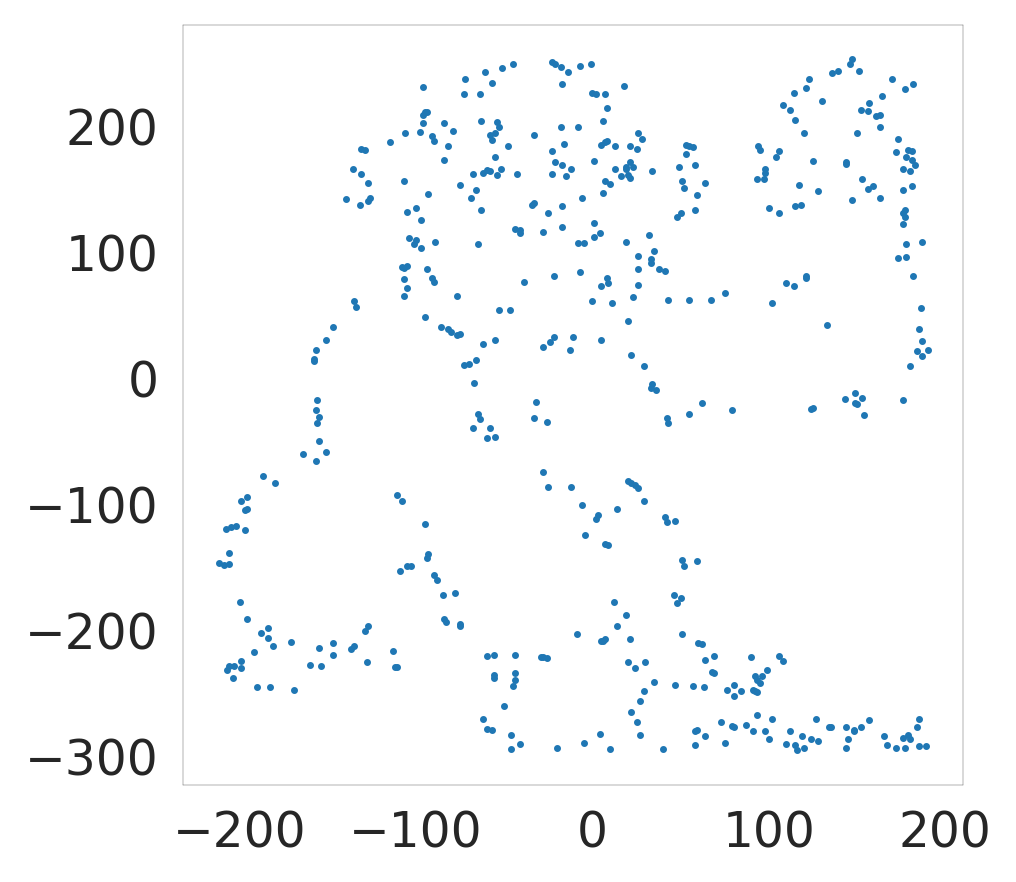

In [15]:
samp = coords.iloc[np.random.choice(coords.shape[0], size=500, replace=False)]
plt.scatter(samp["x"], samp["y"], s=1)

In [16]:
coords = np.array([samp['x'], samp['y']])

**Run Picasso with coordinates**

In [17]:
#Run Picasso
p = Picasso(n_latent = 2, epochs = 250, batch_size = 500)

#Get losses and latent space representation
lossesEl, latentEl = p.fit(scaled_mat, coords, frac = 0.5, silent=False, ret_loss=True) #frac

====> Epoch: 0 Average loss: 97.0865
====> Epoch: 1 Average loss: 96.7664
====> Epoch: 2 Average loss: 96.6295
====> Epoch: 3 Average loss: 96.4957
====> Epoch: 4 Average loss: 96.3648
====> Epoch: 5 Average loss: 96.2115
====> Epoch: 6 Average loss: 96.0566
====> Epoch: 7 Average loss: 95.8863
====> Epoch: 8 Average loss: 95.6831
====> Epoch: 9 Average loss: 95.4768
====> Epoch: 10 Average loss: 95.2215
====> Epoch: 11 Average loss: 94.9797
====> Epoch: 12 Average loss: 94.6612
====> Epoch: 13 Average loss: 94.3341
====> Epoch: 14 Average loss: 93.9907
====> Epoch: 15 Average loss: 93.6018
====> Epoch: 16 Average loss: 93.1618
====> Epoch: 17 Average loss: 92.6413
====> Epoch: 18 Average loss: 92.1639
====> Epoch: 19 Average loss: 91.5727
====> Epoch: 20 Average loss: 90.9902
====> Epoch: 21 Average loss: 90.2883
====> Epoch: 22 Average loss: 89.5732
====> Epoch: 23 Average loss: 88.8366
====> Epoch: 24 Average loss: 88.0204
====> Epoch: 25 Average loss: 87.0987
====> Epoch: 26 Averag

Plot output

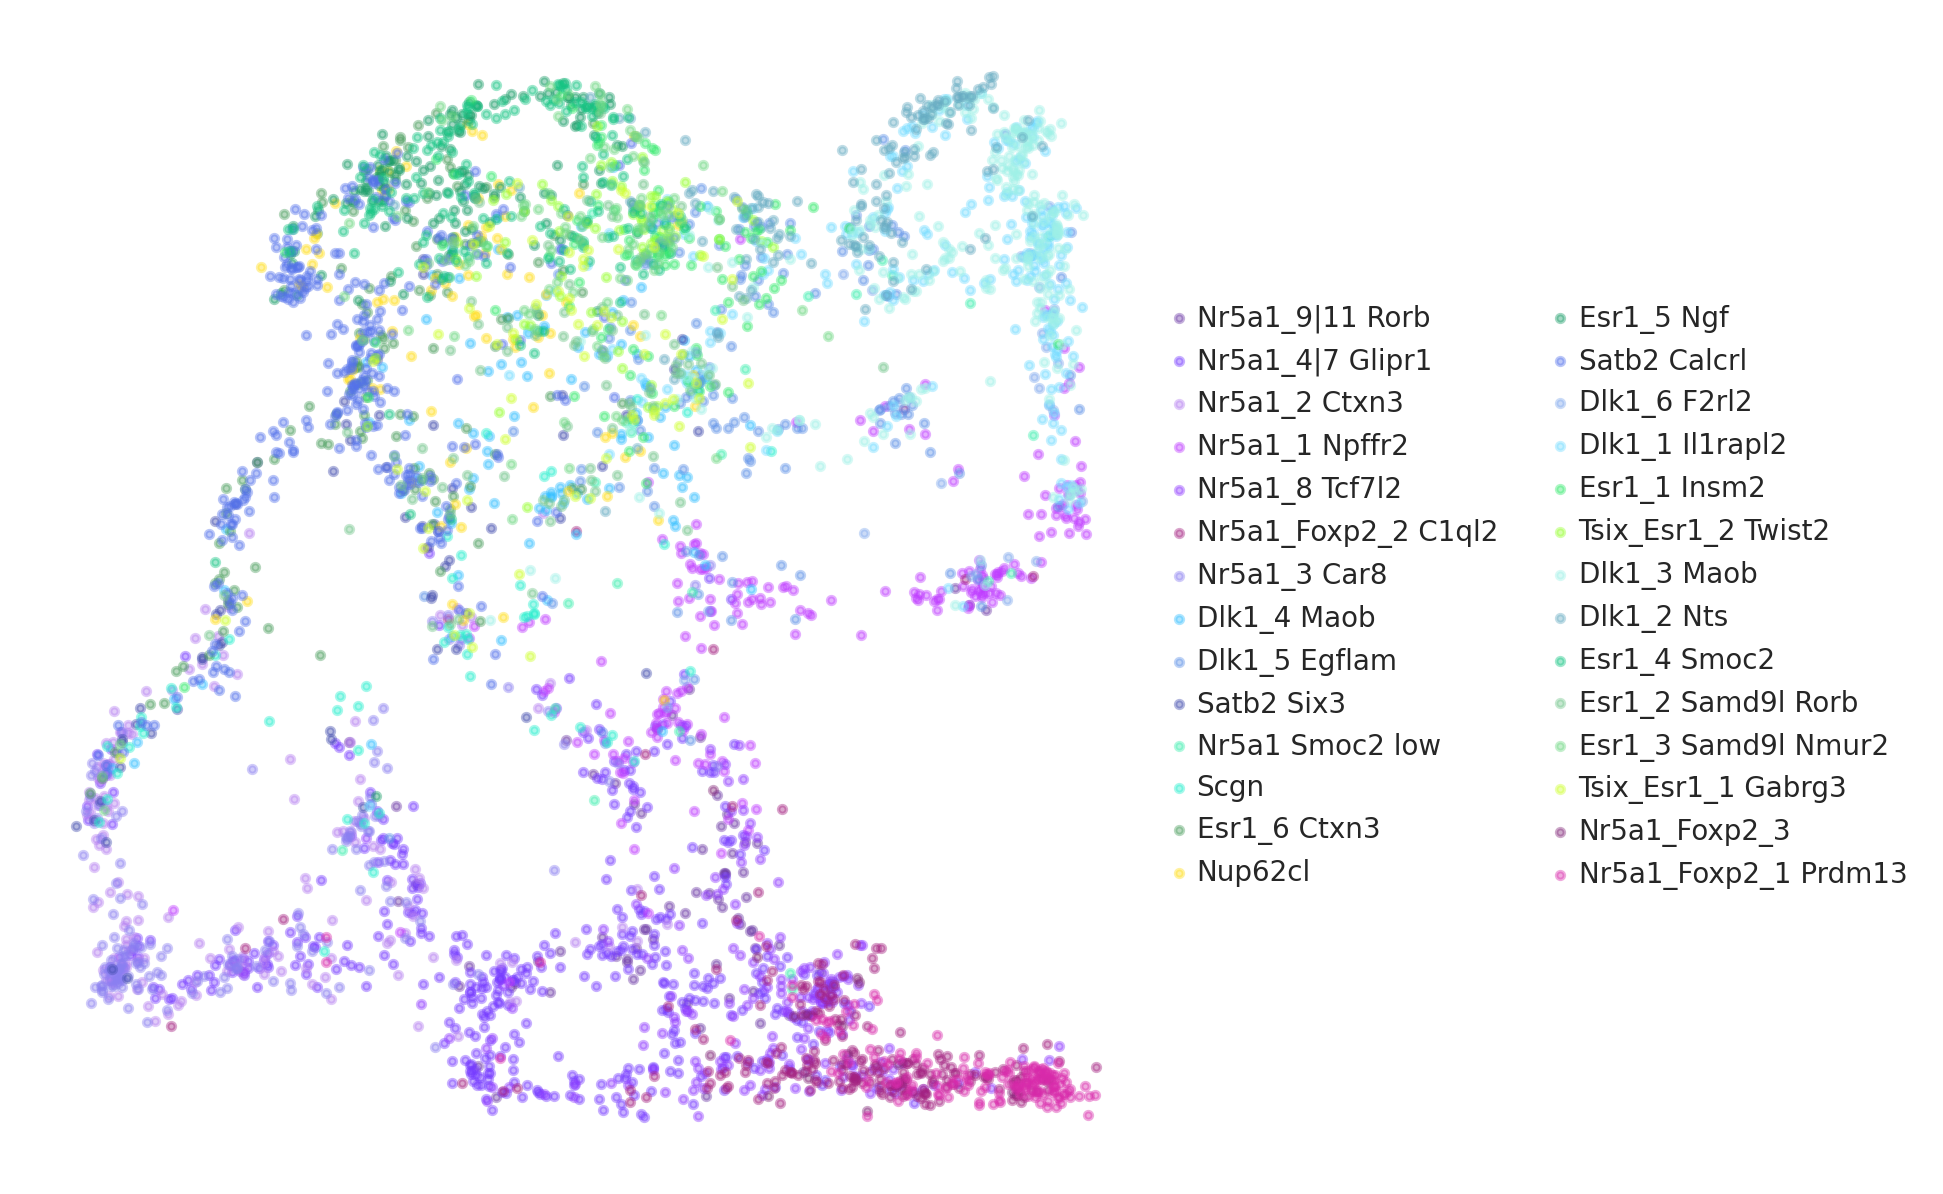

In [18]:
obj_plot_embed(latentEl, meta.smartseq_cluster, fname = 'picasso.pdf', colors=clus_colors ,figsize=(8,5))

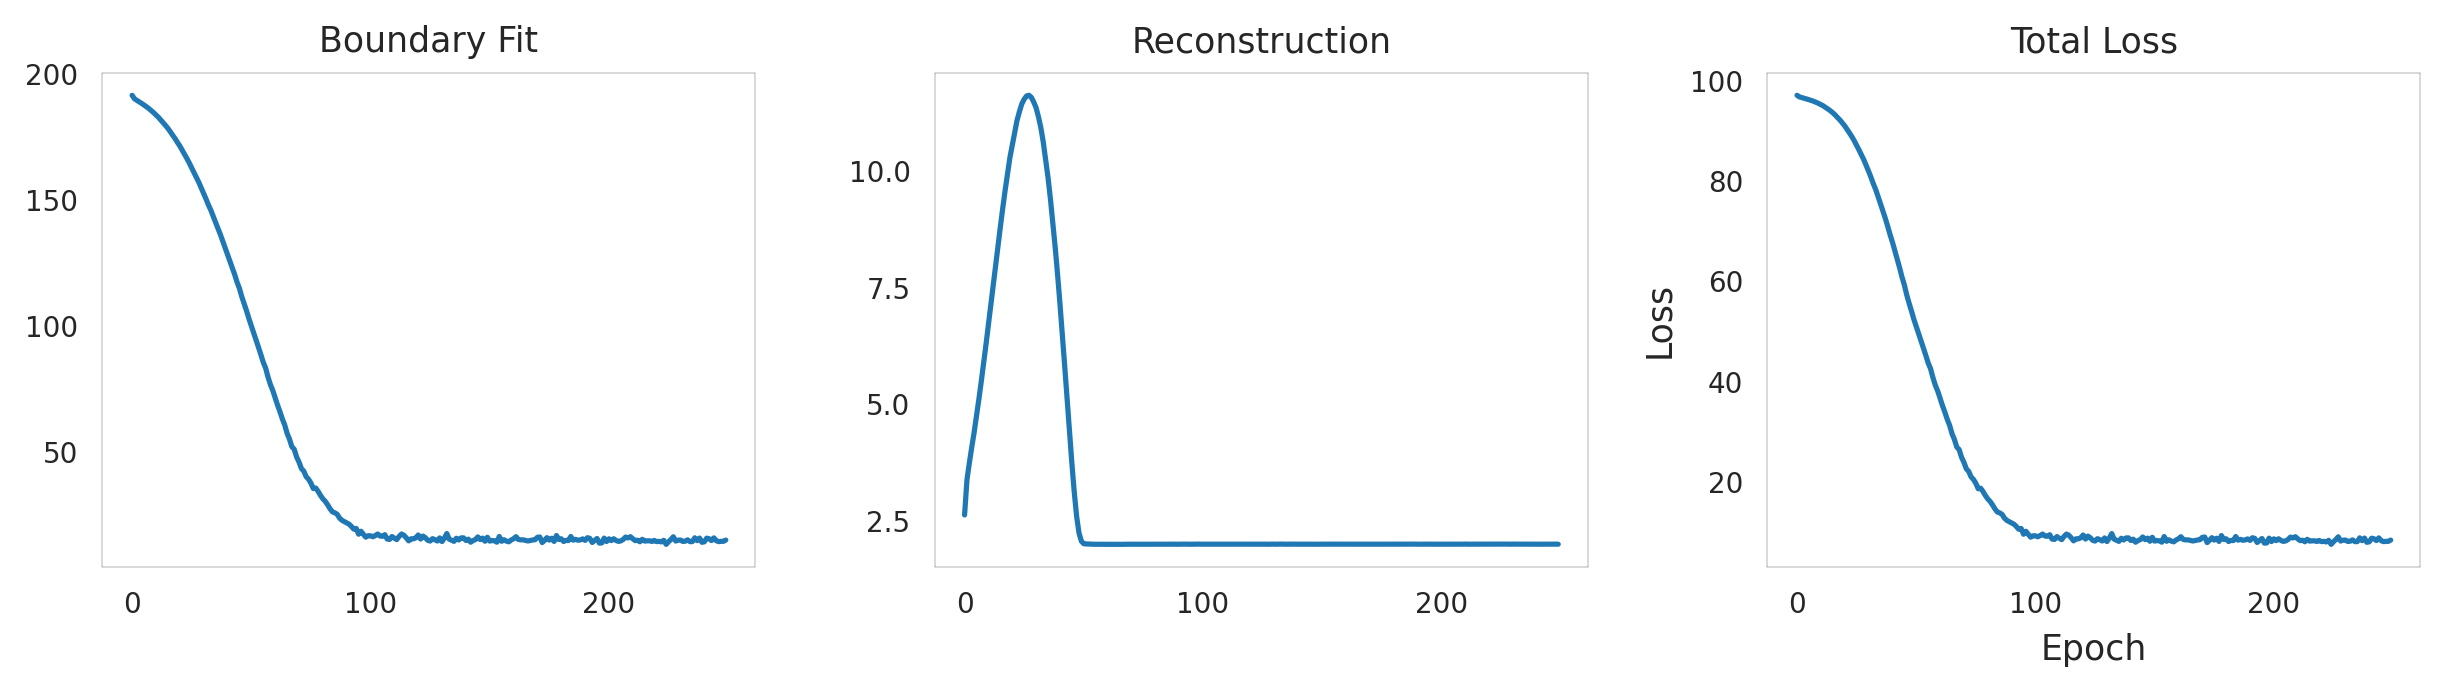

In [19]:
p.plotLosses(figsize=(10,3),axisFontSize=10,tickFontSize=8)